In [1]:
using Knet#: Knet, minibatch, param, param0, softmax, nll, bmm, relu, dropout, progress!, adam
using Knet: AutoGrad.@primitive
using CUDA: CuArray
using Pickle
using NPZ
using Statistics: mean, std
using StatsBase: sample, Weights
using DataStructures: OrderedDict
using LinearAlgebra
using OMEinsum
using Plots

[ Info: OMEinsum loaded the CUDA module successfully


# Model

### Base Layers 

In [2]:
struct Linear; W; b; end
Linear(i::Int, o...) =
    Linear(param(o..., i, atype=ATYPE), param0(o..., atype=ATYPE))
(l::Linear)(x) =
    reshape(reshape(l.W,:,size(l.W)[end]) * reshape(x,size(x)[1],:), size(l.W)[1:end-1]..., size(x)[2:end]...) .+ l.b

struct Activation; f; o; end
Activation(f, o...) = 
    Activation(f, o)
(a::Activation)(x) =
    a.f.(x, a.o...)

struct Embedding; W; end
Embedding(n_ttypes::Int, embed::Int) =
    Embedding(param(embed, n_ttypes, atype=ATYPE))
(e::Embedding)(x) = 
    e.W[:, x] * √size(e.W, 1)

struct Dropout; p; end
(d::Dropout)(x) =
    dropout(x, d.p)

struct LayerNorm; W; b; ϵ; end
LayerNorm(d_model; eps=1e-6) = 
    LayerNorm(param(d_model; init=ones, atype=ATYPE),
              param(d_model, init=zeros, atype=ATYPE),
              eps)
function (ln::LayerNorm)(x, o...; dims=1)
    μ = mean(x, dims=dims)
    σ = std(x, mean=μ, dims=dims, corrected=false)
    ln.W .* (x .- μ) ./ (σ .+ eltype(x)(ln.ϵ)) .+ ln.b
end

struct PositionalEncoding; W; dropout; end
function PositionalEncoding(d_model::Int; dropout=0.1, max_len=20000)
    W = zeros(d_model, max_len)
    pos = exp.((0:2:d_model-1) .* (-log(10000)/d_model)) * (0:max_len-1)'
    W[1:2:end, :] = sin.(pos)
    W[2:2:end, :] = cos.(pos)
    PositionalEncoding(ATYPE(W), Dropout(dropout))
end
function (pe::PositionalEncoding)(x)
    pe.dropout(x .+ pe.W[:, 1:size(x,2), :])
end

struct Chain; layers; end
Chain(l, l_...) =
    Chain(append!(Vector{Any}([l]), l_))
function (c::Chain)(x, o...; state=nothing)
    training = state == nothing
    for layer in c.layers
        if (typeof(layer) != TransformerEncoder) || training
            x = layer(x, o...)
        else
            x, state = layer(x, o..., state=state)
        end
    end
    training ? x : (x, state)
end

### Attention Layer

In [3]:
# https://arxiv.org/pdf/2006.16236.pdf
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/attention/attention_layer.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/recurrent/attention/self_attention/attention_layer.py
struct Attention; q; k; v; o; inner; masker; end
Attention(d_model::Int, n_heads::Int, inner, masker) =
    Attention(Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model÷n_heads, n_heads),
              Linear(d_model, d_model),
              inner, masker)
function (a::Attention)(q, k, v; state=nothing)
    training = state==nothing
    if training
        _, T, B = size(q); H = size(a.q.W, 2)

        q = reshape(a.q(q), (T, :, H, B))
        k = reshape(a.k(k), (T, :, H, B))
        v = reshape(a.v(v), (T, :, H, B))

        o = a.inner(q, k, v, mask=a.masker(T))
        return a.o(reshape(o, (:, T, B)))
    else
        _, _, B = size(q); H = size(a.q.W, 2)

        q = reshape(a.q(q), (B, H, :))
        k = reshape(a.k(k), (B, H, :))
        v = reshape(a.v(v), (B, H, :))
    
        v_, state = a.inner(q, k, v, state=state)
        o = a.o(reshape(v_, (:, B)))
        return o, state
    end
end
(a::Attention)(x; state=nothing) = a(x, x, x, state=state)

### Causal Linear Attention

In [4]:
# https://arxiv.org/pdf/2006.16236.pdf
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/attention/causal_linear_attention.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/recurrent/attention/self_attention/linear_attention.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/causal_product/causal_product_cpu.cpp
function causal_linear_attention(q, k, v; ϕ=gelu, ϵ=1e-6, mask=nothing, state=nothing)
    training = state==nothing
    if training
        Q = ϕ.(q)
        K = ϕ.(k)
        K_ = permutedims(cumsum(permutedims(K, [2,1,3,4]), dims=2), [2,1,3,4])
        Z = 1 ./ (sum(Q .* K_, dims=2) .+ ϵ)
        S = bmm(K, v, transB=true)
        S = S .* mask
        QS = bmm(Q, S, transA=true)
        V = permutedims(QS, [2,1,3,4])
        return V .* Z
    else
        Q = ϕ.(q)
        K = ϕ.(k)
        if state=="init"
            Si = ATYPE(zeros(size(Q)..., size(v,3)))
            Zi = ATYPE(zeros(size(Q)...))
        else
            Si, Zi = state
        end
        @assert size(Si, 1) == size(Q, 1)
        Zi = Zi .+ K
        Si = Si .+ ein"bhd, bhm -> bhdm"(K, v)
        Z = 1 ./ (ein"bhd, bhd -> bh"(Q, Zi) .+ ϵ)
        V = ein"bhd, bhdm, bh -> bhm"(Q, Si, Z)
        return V, (Si, Zi)
    end
end

gelu(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x^3)));
lower_triangular_mask(N) = ATYPE(Matrix{Float32}(UpperTriangular(ones(N,N))))

lower_triangular_mask (generic function with 1 method)

### Transformer Encoder

In [5]:
# https://arxiv.org/pdf/2006.16236.pdf
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/transformers.py
# https://github.com/idiap/fast-transformers/blob/master/fast_transformers/recurrent/transformers.py
struct TransformerEncoder; attention; drop; norm1; fc; norm2; end
function TransformerEncoder(d_model::Int, d_ff::Int, n_heads::Int, dropout, activation, aparams...)
    TransformerEncoder(
        Attention(d_model, n_heads, causal_linear_attention, lower_triangular_mask),
        Dropout(dropout),
        LayerNorm(d_model),
        Chain(Linear(d_model, d_ff), Activation(activation, aparams...), Dropout(dropout),
            Linear(d_ff, d_model), Dropout(dropout)),
        LayerNorm(d_model))
end
function (enc::TransformerEncoder)(x; state=nothing)
    training = state == nothing
    if training
        x_ = enc.attention(x)
        x = x .+ enc.drop(x_)
        y = x = enc.norm1(x)
        y = enc.fc(y)
        return enc.norm2(x+y)
    else
        x_, state = enc.attention(x, state=state)
        x = x .+ enc.drop(x_)
        y = x = enc.norm1(x)
        y = enc.fc(y)
        return (enc.norm2(x+y), state)
    end
end


### Sampling

In [6]:
function sampling(x; t=1.0, p=nothing)
    x = Vector{Float64}(reshape(x, length(x)))
    x = softmax(x./t)
    x = p!=nothing ? nucleus(x, p) : x
    c = sample(1:length(x), Weights(x))
    return c
end

function nucleus(x, p; ϵ=1e-5)
    x = x./(sum(x)+ϵ)
    i = sortperm(x, rev=true)
    x_ = cumsum(sort(x, rev=true)).>p
    c = sum(x_)>0 ? i[1:findfirst(x_)] : i
    x = [i in c ? x[i] : 0 for i in 1:length(x)]
    x = x./sum(x)
end

nucleus (generic function with 1 method)

### Compound Word Transformer

In [7]:
struct CPTransformer; embeds; fc_in; posenc; enc; projs; proj_blend; end

CPTransformer(n_ttypes::Vector{Int}, embed_sizes::Vector{Int}, d_model::Int, d_inner::Int, n_heads::Int, n_layers::Int, dropout) =
    CPTransformer([Embedding(n, e) for (n, e) in zip(n_ttypes, embed_sizes)],
            Linear(sum(embed_sizes), d_model),
            PositionalEncoding(d_model),
            Chain([TransformerEncoder(d_model, d_inner, n_heads, dropout, relu) for n=1:n_layers]..., LayerNorm(d_model)),
            [Linear(d_model, n) for n in n_ttypes],
            Linear(d_model + embed_sizes[ttypeids["type"]], d_model))

function (model::CPTransformer)(x; y=nothing, state=nothing)
        training = y!=nothing

        if training
                x, loss_mask = x[:, 1:end-1, :], ATYPE(x[:, end, :].-1);        #@show size(x) # (T, N, B)
        elseif state==nothing
                state="init"
        end

        x = vcat([embed(x[:, i, :]) for (embed, i) in
                zip(model.embeds, 1:length(model.embeds))]...);                 #@show size(x) # (D_e, T, B)
        
        x = model.fc_in(x);                                                     #@show size(x) # (D_i, T, B)

        x = model.posenc(x);                                                    #@show size(x) # (D_i, T, B)

        if training 
                h = model.enc(x)
        else 
                h, state = model.enc(x, state=state)
        end;                                                                    #@show size(h) # (D_i, T, B)

        ŷ_t_P = model.projs[ttypeids["type"]](h);                               #@show size(ŷ_t_P) # (N_t, T, B)

        ŷ_t = training ?
                y[:, ttypeids["type"], :] : 
                sampling(ŷ_t_P, p=0.9);                                         #@show size(ŷ_t) # (T, B)
                
        ŷ_τ = vcat([h, model.embeds[ttypeids["type"]](ŷ_t)]...);                #@show size(ŷ_τ) # (D_i + D_t, T, B)

        h_ = model.proj_blend(ŷ_τ);                                             #@show size(h_) # (D_i, T, B)

        ŷ_P = [i!=ttypeids["type"] ? proj(h_) : ŷ_t_P
                for (proj,i) in zip(model.projs, 1:length(model.projs))];       #@show size.(ŷ_P) # (N_T, T, B)|T=[1:7]    


        if training
                losses = [nll(ŷ_P[i].*reshape(loss_mask, (:, size(ŷ_P[i])[2:3]...)), y[:,i,:],
                                average=false)[1]/sum(loss_mask)
                                        for i in 1:length(n_ttypes)]
                loss = mean(losses)
                return loss
        else
                gen = Array{Int64}([
                        sampling(ŷ_P[ttypeids["tempo"]], t=1.2, p=0.9),
                        sampling(ŷ_P[ttypeids["chord"]], p=0.99),
                        sampling(ŷ_P[ttypeids["bar-beat"]], t=1.2),
                        ŷ_t,
                        sampling(ŷ_P[ttypeids["pitch"]], p=0.9),
                        sampling(ŷ_P[ttypeids["duration"]], t=2, p=0.9),
                        sampling(ŷ_P[ttypeids["velocity"]], t=5)
                ])
                return gen, state
        end
end

(model::CPTransformer)(x, y) = model(x, y=y)
(model::CPTransformer)(d::Knet.Data) = mean(model(x, y) for (x, y) in d)

### Knet AutoGrad for Cumsum

In [8]:
# TODO: Is this correct?
@primitive cumsum(x; dims::Integer),dy,y  (cumsum(x.*dy, dims=dims)./y)

# Experiment

### Settings

In [11]:
RUN_SMALL_MODEL = false

# Model settings
if RUN_SMALL_MODEL
    # Small model for debugging
    BATCH_SIZE = 4 ÷ 2
    EMBED_SIZES = [128, 256, 64, 32, 512, 128, 128] .÷8
    D_MODEL = 512 ÷16
    D_INNER = 2048 ÷16
    N_HEADS = 8 ÷4
    N_LAYERS = 12 ÷6
    DROPOUT = 0.1
else
    # Original model size
    BATCH_SIZE = 4 ÷2
    EMBED_SIZES = [128, 256, 64, 32, 512, 128, 128]
    D_MODEL = 512 ÷2
    D_INNER = 2048 ÷2
    N_HEADS = 8 ÷2
    N_LAYERS = 12 ÷2
    DROPOUT = 0.1
end

# Learning settings
N_EPOCH = 20
LR = 1e-4

# GPU settings
ATYPE = CuArray;

### Load Data

In [12]:
# dir = "..\\..\\..\\datasets\\Pop1K7\\Pop1K7-CP"
cd(homedir());cd("..");cd("..");cd("..");cd("datasets");cd("Pop1K7");cd("Pop1K7-CP")
t2i, i2t = Pickle.load(open("dictionary.pkl"))
train = NPZ.npzread("train_data_linear.npz")
test = NPZ.npzread("test_data_linear.npz")
cd(homedir())

ttypeids = OrderedDict("tempo"=>1,"chord"=>2,"bar-beat"=>3,"type"=>4,"pitch"=>5, "duration"=>6, "velocity"=>7) # token type ids
n_ttypes = [length(t2i[k]) for (k, v) in ttypeids];

### Minibatching

In [13]:
train_x = trunc.(Int, permutedims(
          cat(train["x"], reshape(train["mask"], (size(train["x"],1),size(train["x"],2),1)), dims=3),
          [2, 3, 1]).+1);                                                                               # @show size(train_x) # T, K+1, B
train_y = trunc.(Int, permutedims(train["y"], [2, 3, 1]).+1);                                           # @show size(train_y) # T, K, B
test_x = trunc.(Int, permutedims(
         cat(test["x"], reshape(test["mask"], (size(test["x"],1),size(test["x"],2),1)), dims=3),
         [2, 3, 1]).+1);                                                                                # @show size(test_x) # T, K+1, B
test_y = trunc.(Int, permutedims(test["y"], [2, 3, 1]).+1);                                             # @show size(test_y) # T, K, B

train_loader = minibatch(train_x, train_y, BATCH_SIZE; shuffle=true)
test_loader = minibatch(test_x, test_y, BATCH_SIZE; shuffle=true)

length.((train_loader, test_loader));

### Training

In [14]:
Knet.seed!(121212)
model = CPTransformer(n_ttypes, EMBED_SIZES, D_MODEL, D_INNER, N_HEADS, N_LAYERS, DROPOUT)
train_losses = []; test_losses = []
for epoch in 1:N_EPOCH+1
    train_loss = model(train_loader); append!(train_losses, train_loss)
    test_loss = model(test_loader); append!(test_losses, test_loss)
    println("Epoch #$(epoch-1) | Train Loss: $(train_loss) | Test Loss: $(test_loss)")
    if epoch == N_EPOCH+1 break; end
    if train_loss<=0.05 break; end
    adam!(model, train_loader, lr=LR)
end

Epoch #0 | Train Loss: 7.003923977208512 | Test Loss: 9.6912366121113
Epoch #1 | Train Loss: 4.058409500601285 | Test Loss: 6.612947665345753
Epoch #2 | Train Loss: 4.0509957901940465 | Test Loss: 6.612565540474933
Epoch #3 | Train Loss: 4.061101489872582 | Test Loss: 6.443135870736285
Epoch #4 | Train Loss: 4.034590997950635 | Test Loss: 6.499217081785157
Epoch #5 | Train Loss: 4.023097211101674 | Test Loss: 6.349373798914091
Epoch #6 | Train Loss: 4.041295094016999 | Test Loss: 6.524848180596565
Epoch #7 | Train Loss: 4.047148773975202 | Test Loss: 6.605444499228042
Epoch #8 | Train Loss: 4.0515743880375625 | Test Loss: 6.393858751171974
Epoch #9 | Train Loss: 4.038084723917413 | Test Loss: 6.593461417195264
Epoch #10 | Train Loss: 4.039053119873245 | Test Loss: 6.641806643666159
Epoch #11 | Train Loss: 4.060407888058052 | Test Loss: 6.388094245629831
Epoch #12 | Train Loss: 4.045512229129938 | Test Loss: 6.568225444967714
Epoch #13 | Train Loss: 4.0148259214313455 | Test Loss: 6.443

Final Results | Train Loss: 4.0299144580644 | Test Loss: 6.852181682815944


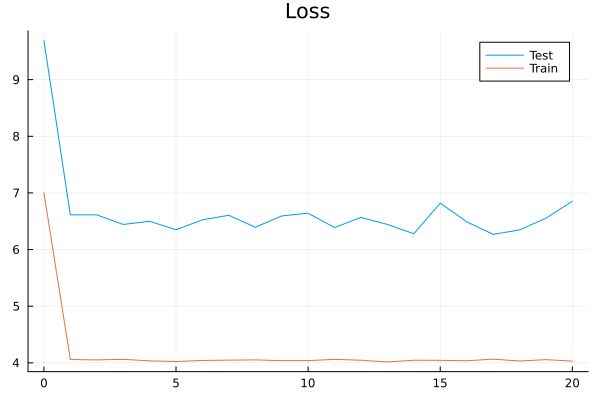

In [15]:
println("Final Results | Train Loss: $(train_losses[end]) | Test Loss: $(test_losses[end])")
loss_plot = plot(0:length(test_losses)-1, [test_losses, train_losses], labels=["Test" "Train"], title="Loss")
display(loss_plot)

In [16]:
x = ATYPE([1,1,2,2,1,1,1])
state = nothing
composition = []
bars = 1
while length(composition) < 10000
    x, state = model(reshape(x, (1,7,1)), state=state)
    append!(composition, [reshape(x.-1, (1, 7))])
    if i2t["type"][x[4]-1] == "EOS" break; end
    if i2t["bar-beat"][x[3]-1] == "Bar" bars+=1; end
end
# append!(composition, [reshape([0,0,0,0,0,0,0], (1, 7))])
composition = vcat(composition...)

### Generation

In [ ]:
# Save as CP in NP format.
dir = "out"
NPZ.npzwrite("$(dir)\\cp\\comp2.npz", composition)

# PyCall
# using PyCall
# pushfirst!(PyVector(pyimport("sys")."path"), "")
# write_midi = pyimport("write_midi")
# Load midi function.
# Load CP in NP format.
# Load word2event dictionary.
# Call function (composition, src, word2event)